In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import requests
from PIL import Image
import io

## URLから画像データの取得、とりあえず透明度の情報は無視

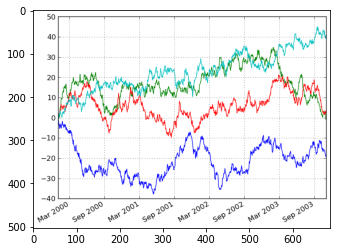

In [2]:
url = "https://pandas.pydata.org/pandas-docs/version/0.7.3/_images/frame_plot_basic_noleg.png"
im = np.array(Image.open(io.BytesIO(requests.get(url).content)))[::-1]/255
if im.shape[2] == 4:im = im[:,:,:-1]
h, w, _ = im.shape
plt.imshow(im[::-1])

## 後のスケール調節用にグラフの範囲のみトリミング

In [3]:
@interact(x_min=(0, w), x_max=(0, w), y_min=(0,h), y_max=(0,h))
def Plot(x_min=0, x_max=w, y_min=0, y_max=h):
    global imag
    plt.figure(figsize=(7, 7))
    imag = im[min(y_min,y_max-1):max(y_min+1, y_max), min(x_min,x_max-1):max(x_min+1, x_max)]
    plt.imshow(imag[::-1])

interactive(children=(IntSlider(value=0, description='x_min', max=687), IntSlider(value=687, description='x_ma…

## 色域選択で抽出したいグラフを選択, Threshold(閾値)を調節して無駄な部分が入らないようにする

In [4]:
@interact(x=(0, imag.shape[1]), y=(0,imag.shape[0]), thresh=(1,10))
def Plot(x, y, thresh):
    global p
    p = ((imag - imag[y, x]) ** 2).sum(axis=2) < (1 / (1<<thresh))
    print(p.sum())
    plt.imshow(p[::-1])
    plt.plot([x, x], [0, imag.shape[0]], color="r")
    plt.plot([0, imag.shape[1]], [imag.shape[0]-y, imag.shape[0]-y], color="r")

interactive(children=(IntSlider(value=308, description='x', max=617), IntSlider(value=209, description='y', ma…

## 縦軸方向に平均を取る

In [5]:
p = np.pad(p, 1, "constant")
sx = np.arange(len(p[0]))[p.argmax(axis=0)!=0]
sy = []

for i in p.T:
    j = np.where(i!=0)[0]
    if j.tolist():
        sy.append(j.mean())

## サンプル数の選択, 移動平均（畳み込み）でノイズの除去

In [6]:
@interact(sample=(5, 1250), conv_size=(1, 21, 2))
def fit(sample, conv_size):
    global y
    x = np.linspace(sx.min(), sx.max(), sample)
    y = np.convolve(np.pad(np.interp(x, sx, sy), (conv_size-1)//2, "edge"), np.ones(conv_size) / conv_size, "valid")
    plt.plot(x, y)
    plt.xlim(0,len(p[0]))
    plt.ylim(0, len(p))

interactive(children=(IntSlider(value=627, description='sample', max=1250, min=5), IntSlider(value=11, descrip…

## 最初に切り取ったグラフの範囲を入力

In [7]:
yl = list(map(int,input("Y-range of trimmed graph?         ").split(",")))

Y-range of trimmed graph?         -40,50


## スケール調整, 出力

In [8]:
y_out = y * (yl[1] - yl[0]) / p.shape[0] + yl[0]
y_out

array([4.78571429, 4.99468146, 5.20364863, ..., 1.56611003, 1.46162644,
       1.35714286])

## グラフ出力

(-40.0, 50.0)

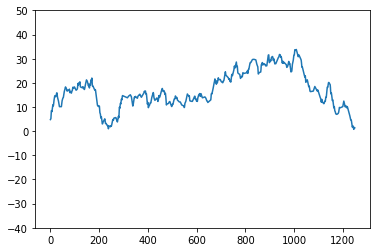

In [9]:
plt.plot(y_out)
plt.ylim(*yl)